In [1]:
import pandas as pd
import numpy as np
import os
import json
import copy
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import path

from pathwayenrichment.representation import ClusterPermutator
from pathwayenrichment.databaseparser import KEGGPathwayParser 

import Dokdonia_code as Dc

plt.style.use('plt_styles.mplstyle')
%matplotlib inline

# Load count data

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


# Find DE genes between Light and Dark

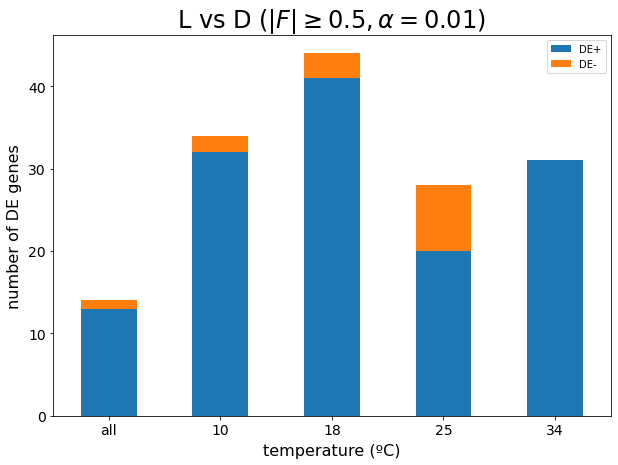

In [7]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = Dc.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = Dc.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [9]:
L_D_stats['18']

{'DE+': 41, 'DE-': 3}

We find DE genes, with a absolute fold cutoff value $|K|\geq0.5$ and significance level $\alpha=0.01$ across all temperatures. In all cases, there are more genes with greater expression under light than those with greater expression in the dark.

Let's look at the lists of DE genes across  temperatures:

In [11]:
# L > D, T = 18 Proteins [Sale alguno en cluster?]
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
DE = {}
for T, res in L_D_res.items():
    DE[T] = {
        'L>D': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0]
            for gene_id in res[res.log2FoldChange >= k].index
        },
        'D>L': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0]
            for gene_id in res[res.log2FoldChange <= -k].index
        }
    }
DE['18']

{'L>D': {'MED134_07319': 'hypothetical protein',
  'MED134_07209': 'hypothetical protein',
  'MED134_07119': 'rhodopsin',
  'MED134_07089': 'sensor of blue-light using FAD',
  'MED134_06804': 'two-component system response regulator',
  'MED134_06194': 'hypothetical protein',
  'MED134_06129': 'cold shock domain protein CspD',
  'MED134_05894': 'arginase family protein',
  'MED134_05889': 'Orn/DAP/Arg decarboxylase',
  'MED134_05499': 'hypothetical protein',
  'MED134_05339': 'hypothetical protein',
  'MED134_05334': 'GTP cyclohydrolase I',
  'MED134_04999': 'putative cell adhesion protein',
  'MED134_04254': 'hypothetical protein',
  'MED134_04249': 'hypothetical protein',
  'MED134_04009': 'ATP-dependent protease La (LON)',
  'MED134_03969': 'hypothetical protein',
  'MED134_03869': '50S ribosomal protein L31',
  'MED134_03409': 'hypothetical protein',
  'MED134_03404': 'ABC1 family protein',
  'MED134_15862': 'hypothetical protein',
  'MED134_02025': 'hypothetical protein',
  'MED13

# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [33]:
n_counts = pd.read_csv('Data/Dokdonia_transcripts_cell.csv', index_col=0)
n_counts.iloc[:,1:] = 1e4 * n_counts.iloc[:,1:]

clust_data_TC = n_counts
clust_data_TC = clust_data_TC[clust_data_TC.filter(regex='^[^T]+$').columns]
clust_data_TC = clust_data_TC.set_index('index')
clust_data_TC.index.name = 'ID'
clust_data_TC = clust_data_TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4

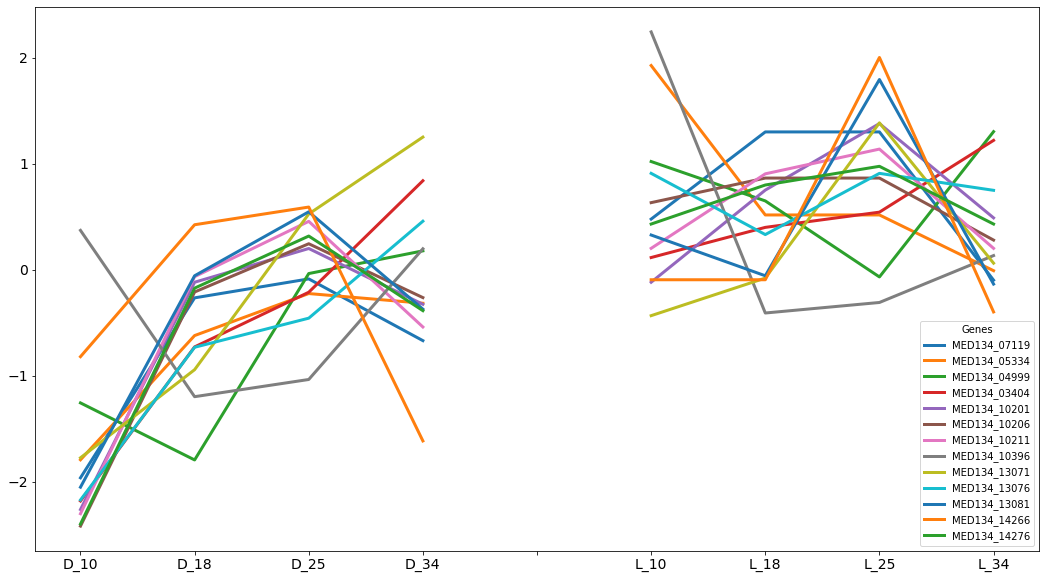

In [78]:
ax = cluster_data.loc[DE['all']['L>D']].transpose().plot(legend=True, figsize=(18, 10))

In [48]:
clust_tightness = 0
clust_data_TC_DE = clust_data_TC.loc[DE_total]
res_id = 'CLUSTER_LD_DE_GENES_TRANSCRIPT_CELL'

workdir = os.path.join(os.getcwd(),'Results')

clusters = Dc.getGeneClusters(clust_data_TC_DE, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_TPM_normalization.txt',
                              replicates_file='clust_replicates.txt')

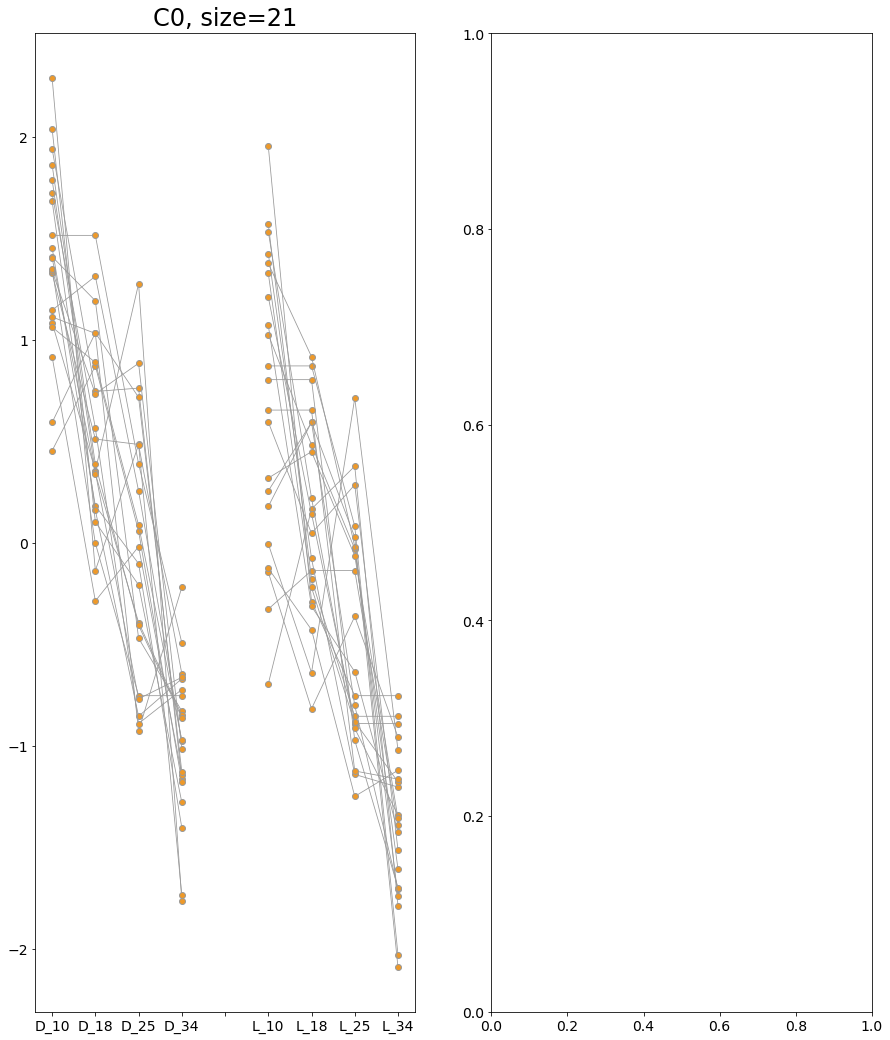

In [49]:
# Plot clusters
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
cluster_data.insert(4, '', [np.nan for n in range(cluster_data.shape[0])])

Dc.plotClusters(cluster_data, clusters)

# Effect of temperature on gene expression: Pathway enrichment analysis

Next, we analyze the effect that temperature may have on gene expression. To this end, we first cluster genes according to their across-temperature expression pattern, and then perform a permutation-based pathway enrichment analysis to evaluate which pathways are most affected by temperature changes.

To separate the effect of light and dark from that of temperature, we leave out of the analysis the set of genes that were DE between light and dark.

## Prepare dataset

In [13]:
# Get light-dark DE genes at any temperature
DE_plus = np.unique([g for res in L_D_res.values() for g in res[res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for res in L_D_res.values() for g in res[res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')

There are a total of 74 DE genes between Light and Dark


In [25]:
# Remove light-dark DE genes from transcript/cell dataset
TC = pd.read_csv('Data/Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC.iloc[:,1:] = 1e4 * TC.iloc[:,1:] # scale data to avoid numerical issues
TC = TC.set_index('index')
TC.index.name = 'ID'

In [26]:
TCnoDE = TC.loc[~TC.index.isin(DE_total)]
TCnoDE.head()

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_25_R2,D_25_R3,D_34_R1,D_34_R2,...,L_18_R1,L_18_R2,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
ID,,,,,,,,,,,,,,,,,,,,,
MED134_07389,3272.742595,4023.255679,3193.191427,15046.001051,25885.970883,18162.634520,12525.337743,13779.248042,17241.568322,14585.675293,...,10636.784088,10242.042265,6006.706745,11627.525559,10910.352316,14970.913156,8945.846865,9695.256532,12718.703565,14741.535906
MED134_07384,392.789657,547.537422,373.996913,2043.866391,3707.295784,2474.589206,1744.778890,1898.573010,2530.246196,2081.393024,...,1443.568271,1615.539610,753.315530,1597.443490,1447.705242,2150.602814,1217.079060,1486.691533,1997.787565,1992.760793
MED134_07379,857.729502,1168.666690,788.719005,3546.304715,6681.586906,4224.249541,2930.021236,3699.854578,4502.661370,3607.912641,...,2381.739097,2882.641856,1344.830021,2679.306861,2357.751168,3449.133396,2295.894691,2383.525449,3360.106180,3524.418456
MED134_07374,501.267212,747.890343,338.332259,1724.020954,3189.035279,1920.596526,1283.141894,1520.526262,1628.184006,1433.720402,...,1195.986244,1132.894001,641.685356,1057.101376,939.857775,1410.549570,937.845577,968.805933,1222.916402,1356.800422
MED134_07369,526.494550,707.749336,508.703275,1854.219173,3220.316908,1986.579667,1337.315556,1377.021384,1904.745799,1451.017297,...,1445.548927,1603.567983,866.952537,1092.180869,1087.347977,1520.546555,1244.596415,1114.940420,1264.876934,1312.703771


## Cluster by gene expression pattern

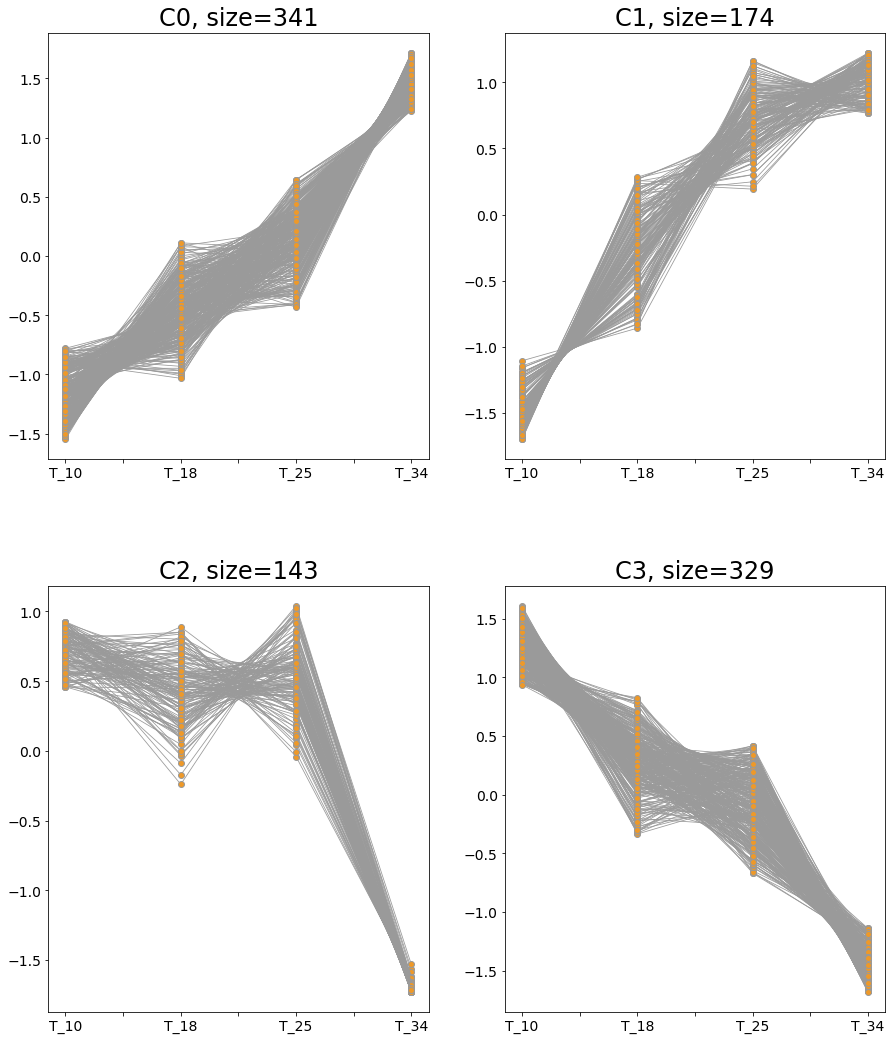

In [33]:
clust_tightness = 4
res_id = 'CLUSTER_NONDE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'Results')

clusters = Dc.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_TPM_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
cluster_data.insert(4, '', [np.nan for n in range(cluster_data.shape[0])])

Dc.plotClusters(cluster_data, clusters)

## Pathway enrichment analysis

In [ ]:
# Parse KEGG Dokdonia's orthology
KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()

# Run analysis
permutator = ClusterPermutator(clusters, gene_pathways, system_pathways)

In [ ]:
pathway_res = permutator.sampleClusterPermutationSpace(sample_size=100000, n_processes=8)
Dc.saveToPickleFile(pathway_res, 'results/enrichment_result_noDEgenes.pkl')

## Visualization